In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import MinMaxScaler

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
%load_ext autoreload
%autoreload 2

## Load Training and Testing Data

In [9]:
(df, train_df, test_df, feature_names, next_two_weeks) = get_features_and_data()

training examples = 2500, testing examples = 327


In [10]:
scaler = MinMaxScaler().fit(train_df[["days_since_previous_release"]])
train_df["days_since_previous_release"] = scaler.transform(train_df[["days_since_previous_release"]])
test_df["days_since_previous_release"] = scaler.transform(test_df[["days_since_previous_release"]])

In [11]:
scaler = MinMaxScaler().fit(df[["days_since_previous_release"]])
df["days_since_previous_release"] = scaler.transform(df[["days_since_previous_release"]])
next_two_weeks["days_since_previous_release"] = scaler.transform(next_two_weeks[["days_since_previous_release"]])

## Model-Building and Evaluation

In [12]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=train_df["prob_of_release"],
                       lower=0, upper=1, shape=features.shape[1])

In [13]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [14]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,1.04,0.03,0.98,1.10,0.0,0.0,3038.19,2710.44,1.0
WD_Tuesday,0.08,0.01,0.05,0.11,0.0,0.0,1998.26,2413.56,1.0
WD_Wednesday,0.08,0.01,0.05,0.10,0.0,0.0,1951.75,2611.82,1.0
WD_Monday,0.06,0.01,0.04,0.09,0.0,0.0,1900.53,2529.92,1.0
WD_Thursday,0.04,0.01,0.02,0.07,0.0,0.0,2051.89,2420.71,1.0
WD_Sunday,0.01,0.01,-0.02,0.04,0.0,0.0,1847.71,2231.24,1.0
month_holidays,0.00,0.00,-0.00,0.01,0.0,0.0,4232.20,2966.20,1.0
WD_Saturday,-0.00,0.01,-0.03,0.02,0.0,0.0,2002.00,2493.42,1.0
previous_release_preorder,-0.03,0.03,-0.09,0.02,0.0,0.0,4332.74,2884.75,1.0


In [15]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.28,0.01,0.26,0.31,0.0,0.0,1493.28,2027.84,1.0
error,0.16,0.00,0.16,0.17,0.0,0.0,4317.93,3135.12,1.0


### Out-of-Sample Evaluation

In [16]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [17]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [18]:
mape(test_df["prob_of_release"], y_pred)

0.2394404387326485

In [19]:
wape(test_df["prob_of_release"], y_pred)

0.22650544658467966

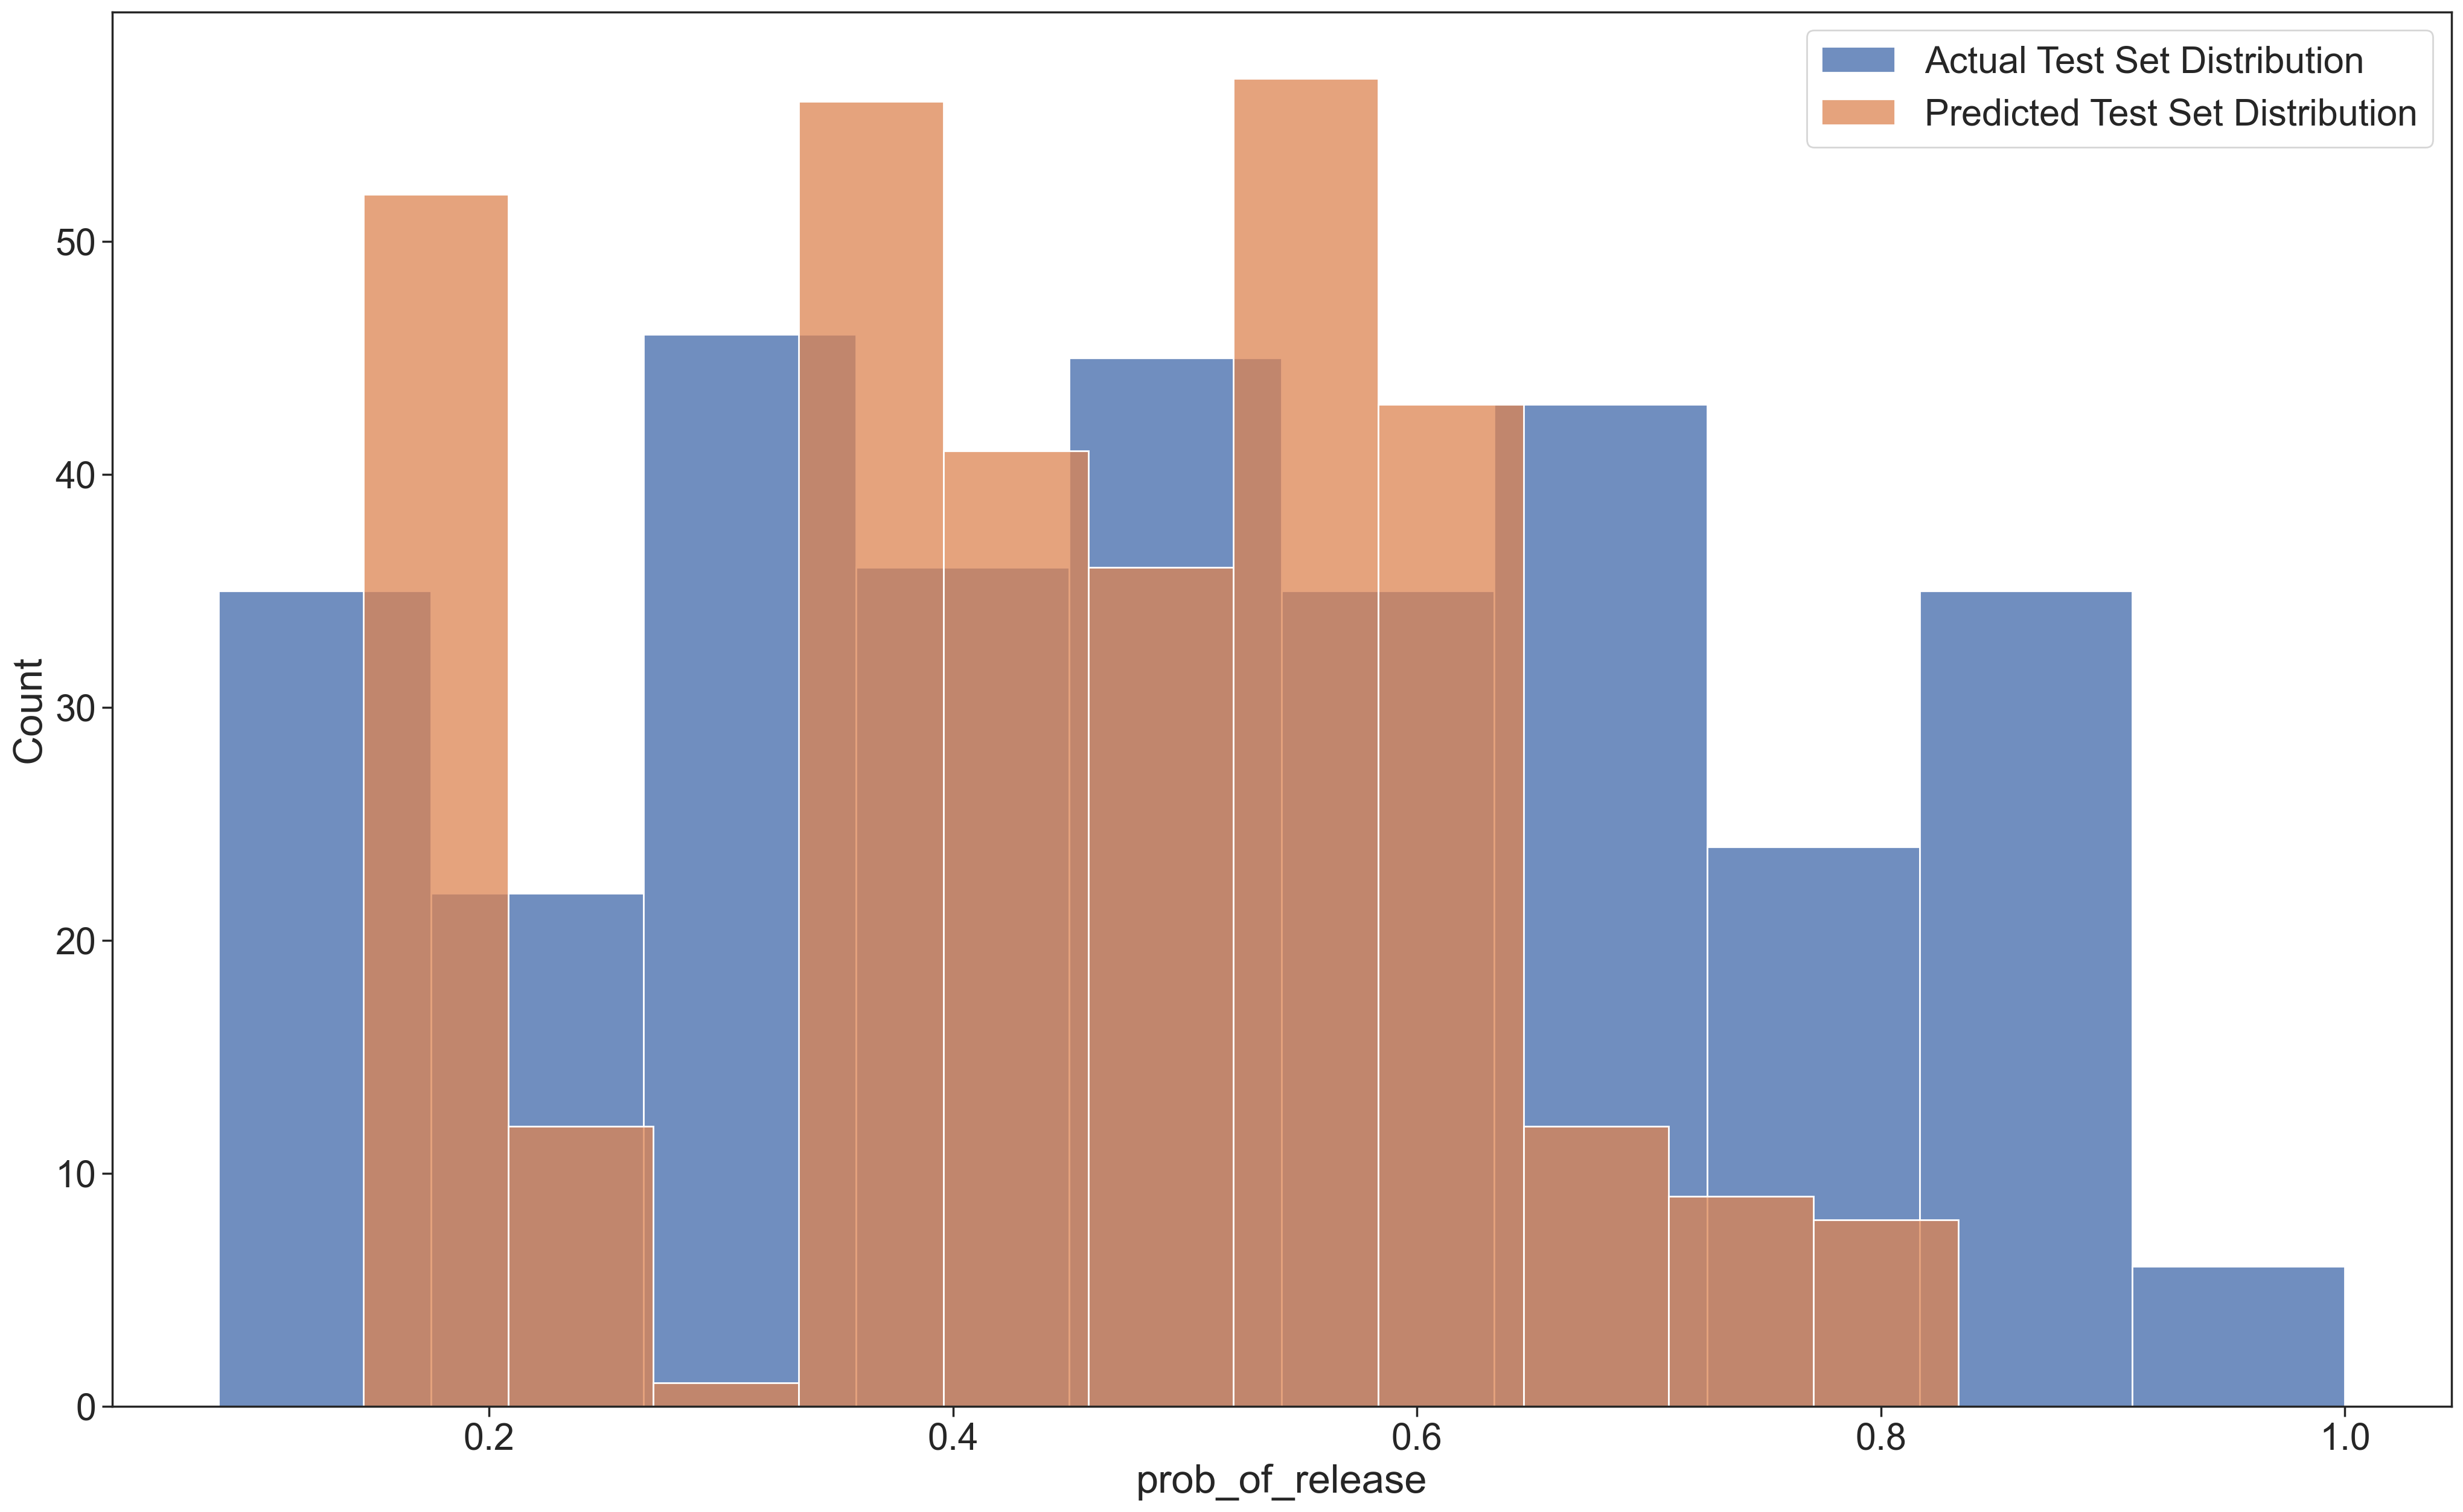

In [20]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=y_pred, ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Two Weeks

In [21]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [22]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [23]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,1.03,0.03,0.97,1.08,0.0,0.0,2937.52,2895.20,1.0
WD_Tuesday,0.09,0.01,0.07,0.12,0.0,0.0,2039.30,2641.69,1.0
WD_Wednesday,0.09,0.01,0.07,0.11,0.0,0.0,1942.09,2690.78,1.0
WD_Monday,0.07,0.01,0.05,0.09,0.0,0.0,2025.38,2775.17,1.0
WD_Thursday,0.06,0.01,0.04,0.08,0.0,0.0,2141.63,2599.58,1.0
WD_Sunday,0.02,0.01,-0.01,0.04,0.0,0.0,1949.99,2462.31,1.0
month_holidays,0.00,0.00,-0.00,0.01,0.0,0.0,3355.41,2374.24,1.0
WD_Saturday,-0.00,0.01,-0.02,0.02,0.0,0.0,2017.64,2600.25,1.0
previous_release_preorder,-0.02,0.03,-0.07,0.03,0.0,0.0,3678.65,2566.63,1.0


In [24]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.29,0.01,0.26,0.31,0.0,0.0,1396.63,2118.96,1.0
error,0.16,0.00,0.16,0.17,0.0,0.0,3815.45,2909.80,1.0


In [25]:
with model:
    pm.set_data({"features" : next_two_weeks[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [26]:
next_two_weeks["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [27]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_two_weeks["predicted_min"] = hdi["y_pred"][:, 0]
next_two_weeks["predicted_max"] = hdi["y_pred"][:, 1]

In [28]:
next_two_weeks[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
0,2024-11-22,0.0001,0.1362,0.3263
1,2024-11-23,0.0000,0.1560,0.3641
2,2024-11-24,0.0330,0.3463,0.6411
3,2024-11-25,0.1279,0.4522,0.7639
4,2024-11-26,0.2101,0.5243,0.8405
5,2024-11-27,0.2755,0.5702,0.9158
6,2024-11-28,0.2719,0.5921,0.9081
7,2024-11-29,0.2811,0.5886,0.9187
8,2024-11-30,0.3501,0.6423,0.9581
9,2024-12-01,0.4412,0.6998,0.9998


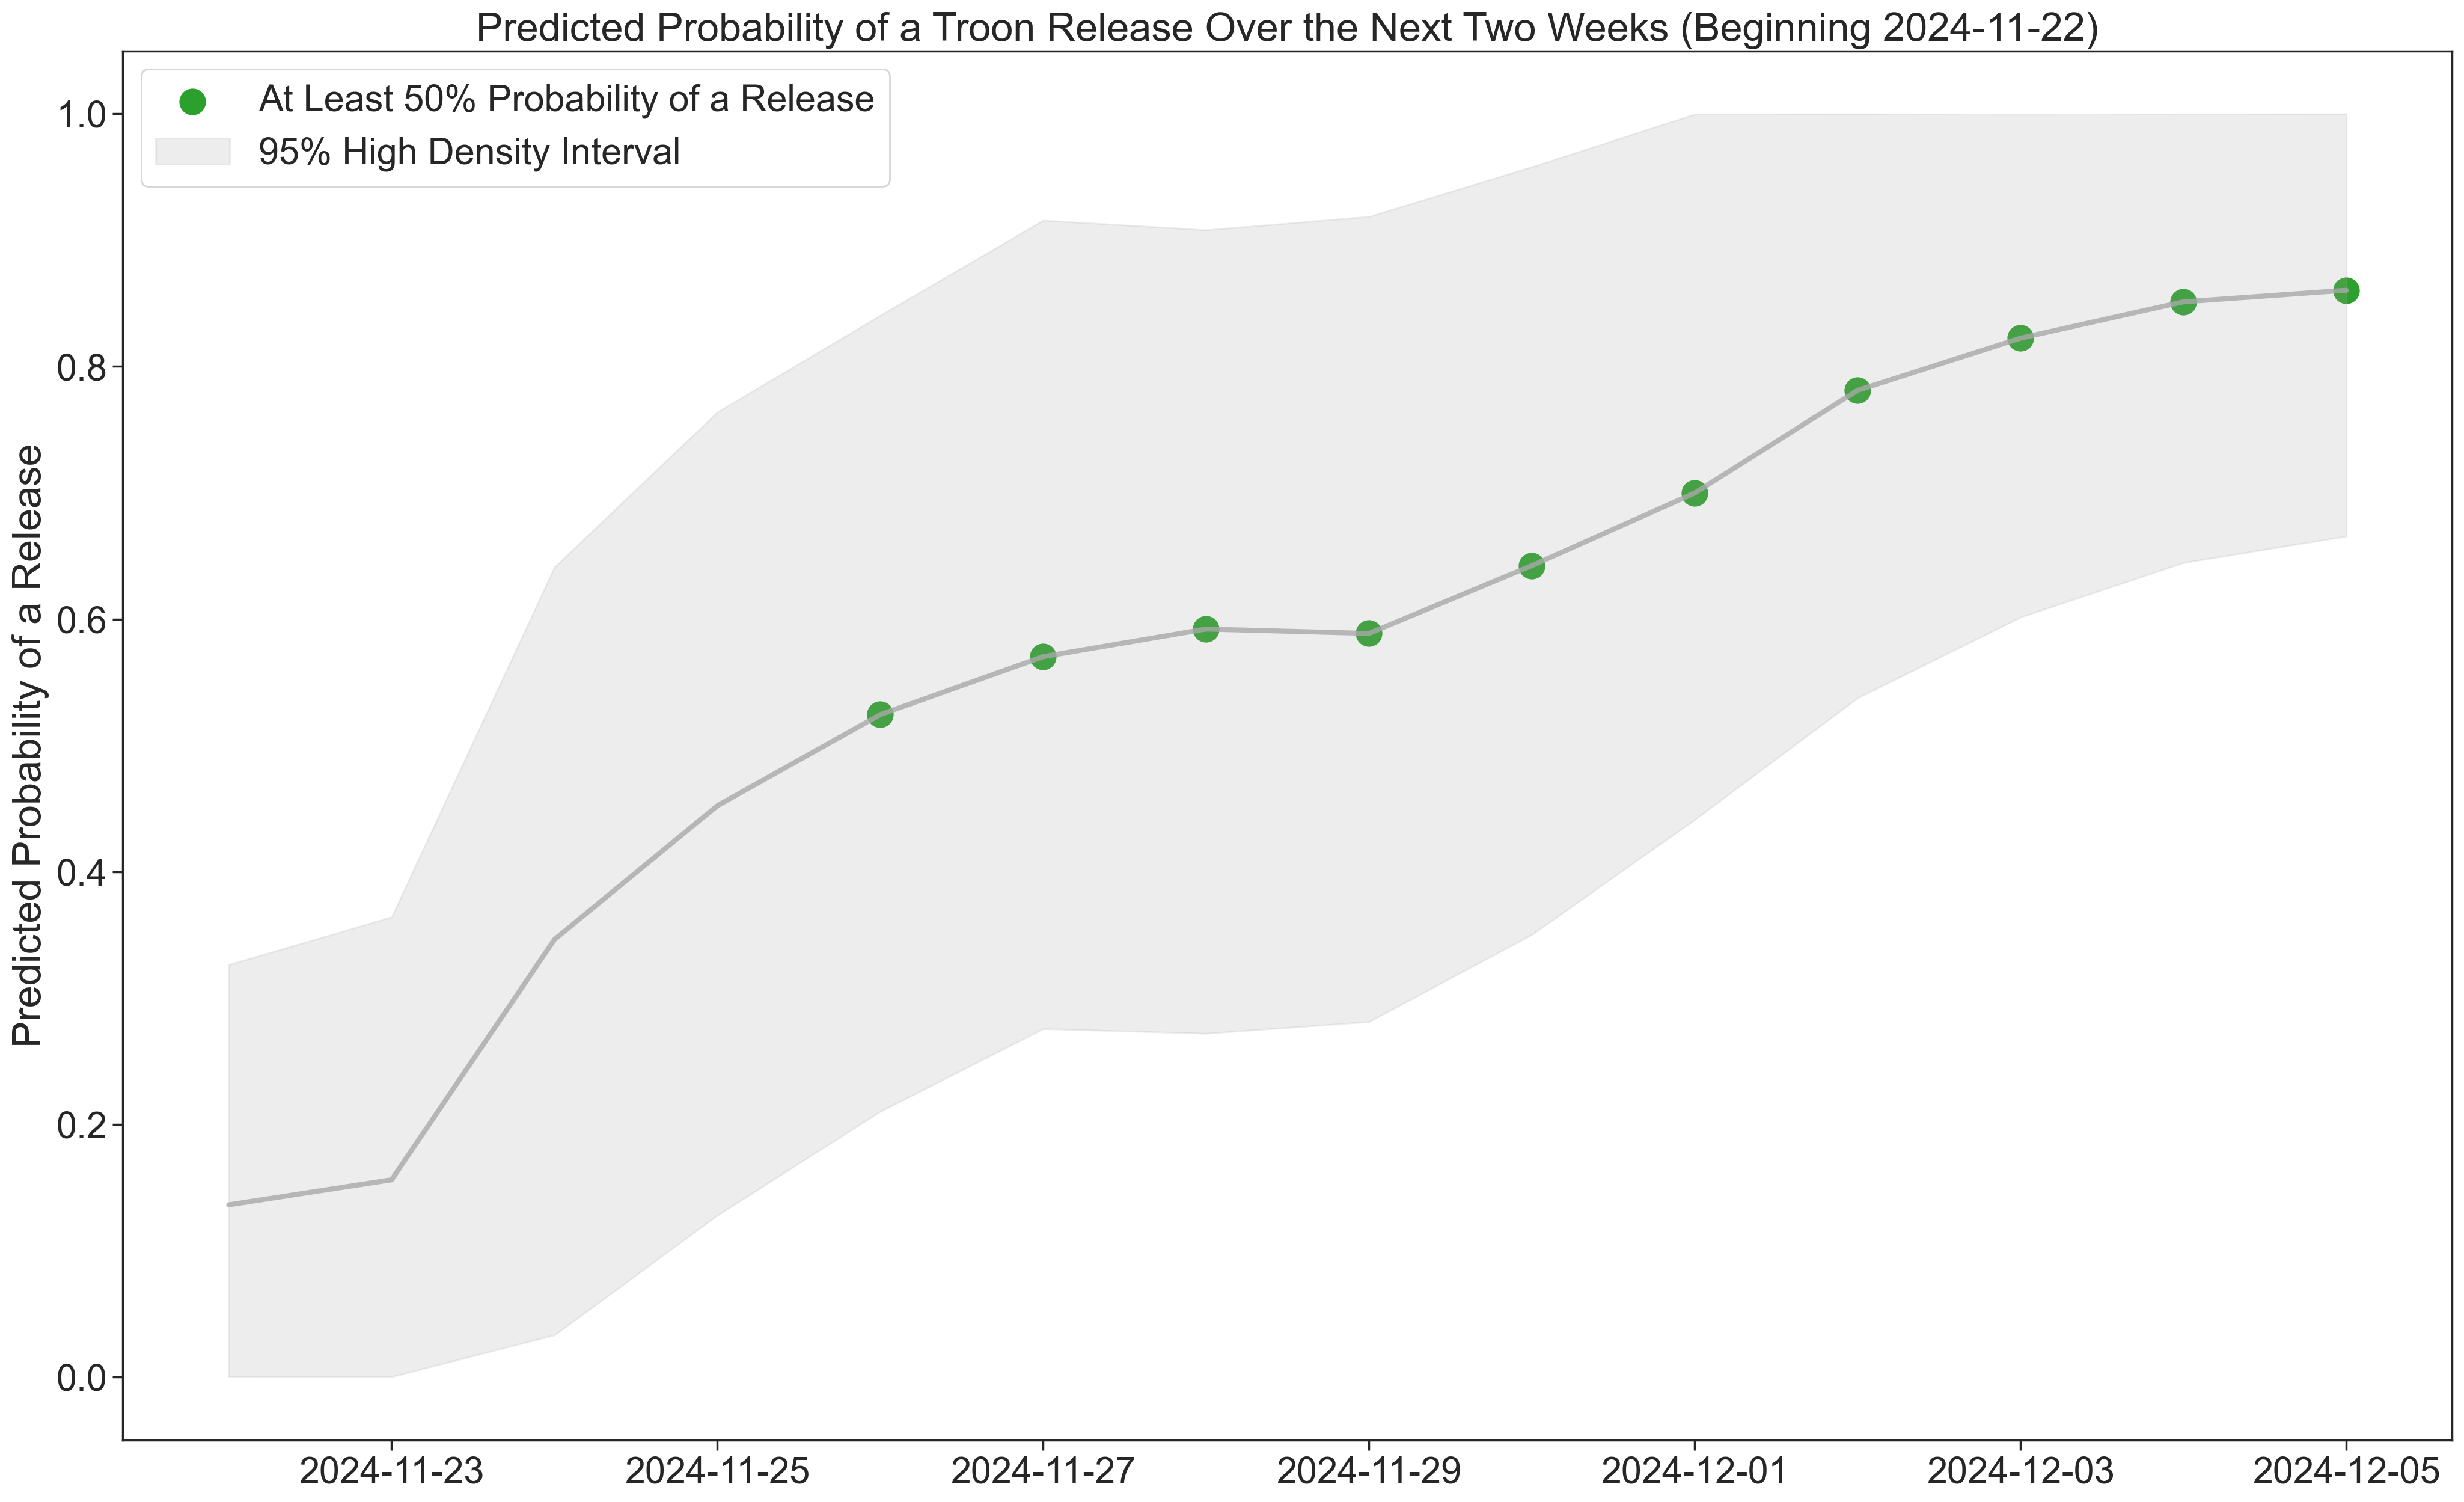

In [29]:
ax = sns.lineplot(data=next_two_weeks, x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_two_weeks[next_two_weeks["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")

ax.fill_between(x=next_two_weeks["index"],
                y1=next_two_weeks["predicted_min"],
                y2=next_two_weeks["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_two_weeks["index"].iloc[0].date()))
ax.legend()
plt.show()